In [1]:
'''
# 라이브러리 정의
 - 시스템 라이브러리
 - 오디오 관련 라이브러리
 - 연산 및 Plot 관련 라이브러리 
 - 샤용자 라이브러리
'''

# Import Systems 
import struct
import io
import os
import sys
import math
import platform

# Import Audio
import pyaudio
import sounddevice
import librosa
import soundfile

import numpy as np
import scipy
import scipy.signal as sig
import matplotlib.pyplot as plt

# User Libraries
import pyOssWavfile
import pyRoomAcoustic as room
import pyOssDebug as dbg
import pyOssFilter


In [2]:
IDX_ASIO = pyaudio.paASIO               # = 3
IDX_COREAUDIO = pyaudio.paCoreAudio     # = 5

if 'darwin' in platform.system():
    IDX = pyaudio.paCoreAudio
elif 'linux' in platform.system():
    IDX = pyaudio.paALSA
else:
    IDX = pyaudio.paWASAPI 

print(IDX)


13


In [3]:

pa = pyaudio.PyAudio()

dev_cnt = pa.get_device_count()

temp1 = pa.get_default_host_api_info()
temp2 = pa.get_device_info_by_index(0)
temp3 = pa.get_device_info_by_host_api_device_index(1, 1)
temp4 = pa.get_host_api_info_by_type(IDX_ASIO)
temp5 = pa.

print('temp1 =', temp1.keys(), temp1.values())
print(temp2)
print(temp3)
print("IDX_ASIO: ", IDX_ASIO)
print(temp4['index'])

# for i in range(0, dev_cnt):
#     name = pa.get_device_info_by_index(i)['name']
#     print(name)

temp1 = dict_keys(['index', 'structVersion', 'type', 'name', 'deviceCount', 'defaultInputDevice', 'defaultOutputDevice']) dict_values([0, 1, 2, 'MME', 8, 1, 5])
{'index': 0, 'structVersion': 2, 'name': 'Microsoft 사운드 매퍼 - Input', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.09, 'defaultLowOutputLatency': 0.09, 'defaultHighInputLatency': 0.18, 'defaultHighOutputLatency': 0.18, 'defaultSampleRate': 44100.0}
{'index': 9, 'structVersion': 2, 'name': 'Headset Microphone(Cirrus Logic CS8409 (AB 16))', 'hostApi': 1, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.12, 'defaultLowOutputLatency': 0.0, 'defaultHighInputLatency': 0.24, 'defaultHighOutputLatency': 0.0, 'defaultSampleRate': 44100.0}
IDX_ASIO:  3
2


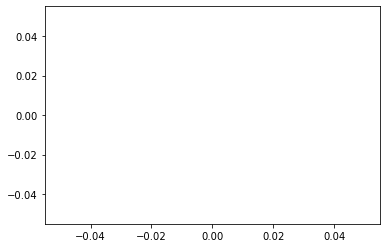

In [4]:
CHUNK = 1024
RATE = 44100            # wave file header에서 읽어오면 됨
BUFFER = CHUNK * 4

stream = pa.open(
    format = pyaudio.paFloat32,
    channels = 1,
    rate = RATE,
    input = True,
    output = False,
    frames_per_buffer = BUFFER
)

fig = plt.figure()
line1 = plt.plot([],[])[0]
line2 = plt.plot([],[])[0]

r = range(0,int(RATE/2+1),int(RATE/BUFFER))
l = len(r)